In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = "https://paperswithcode.com/sota/multi-task-language-understanding-on-mmlu"

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
scripts = soup.find_all('script')


chart_data, table_metrics, table_data = scripts[6:9]

import json
json_table = json.loads(table_data.string)

df  = pd.DataFrame(json_table)
df.to_csv('mmlu_data/mmlu_benchmark_results.csv')
df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
df['mmlu_accuracy'] = df.raw_metrics.apply(lambda x: x['Average (%)'])
df.to_csv('mmlu_data/mmlu_benchmark_results_clean.csv', index=False)

In [165]:
# Did some manual labeling of whether weights were openly available or not -> new CSV file.
# this could probably be automated by checking against the names of the other dataset, but it wasn't standardized

In [1]:
import pandas as pd
df  = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')

df['evaluation_date'] = pd.to_datetime(df['evaluation_date'])

filtered_df = df[df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
# filtered_df = df.sort_values(by='evaluation_date', ascending=True)
# filtered_df = df.sort_values(by='evaluation_date', ascending=True)
filtered_df = filtered_df[['rank', 'method_short', 'evaluation_date', 'mmlu_accuracy', 'open_weights']]


max_score = 0
max_score_list = []

for i,x in filtered_df.iterrows():

    if x.mmlu_accuracy > max_score:
        max_score = x.mmlu_accuracy
        if len(max_score_list) == 0:
            max_score_list.append(x)
        else:
            if max_score_list[-1].evaluation_date == x.evaluation_date:
                max_score_list[-1] = x
            else:
                max_score_list.append(x)

open_top_params = [125000000, 1500000000, 11000000000, 20000000000, 65000000000, 180000000000, 35000000000, 72000000000, 142000000000,405000000000]

/var/folders/c9/bx81pd553cn7j4z_dnfy0mmr0000gn/T/ipykernel_84005/3404423349.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['evaluation_date'] = pd.to_datetime(df['evaluation_date'])


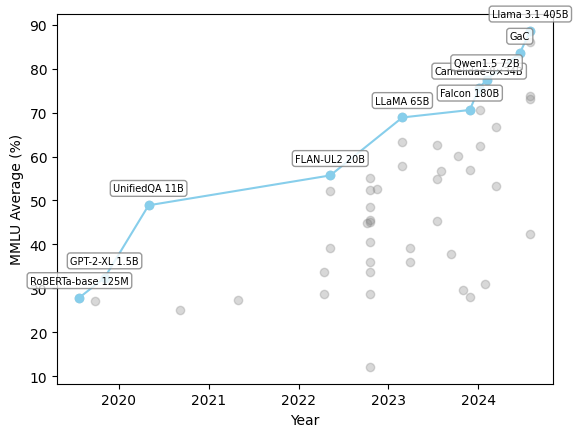

In [2]:
import matplotlib.pyplot as plt

# plt.scatter(pd.to_datetime(df['evaluation_date']), df['mmlu_accuracy'], color='red')
plt.scatter(pd.to_datetime(filtered_df['evaluation_date']), filtered_df['mmlu_accuracy'], color='gray', alpha=0.3)
plt.plot([x.evaluation_date for x in max_score_list], [x.mmlu_accuracy for x in max_score_list], color='skyblue')
plt.scatter([x.evaluation_date for x in max_score_list], [x.mmlu_accuracy for x in max_score_list], color='skyblue')



# Add annotations for max_score_list points
for i, point in enumerate(max_score_list):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.mmlu_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.ylabel("MMLU Average (%)")
plt.xlabel("Year")
plt.show()



In [ ]:
# df_research.columns, df_released.columns

# line that plots size of most performant open model over time.
# scatter plot of model sizes people are using 

In [3]:
import pandas as pd

# Set up the data
df_research = pd.read_csv('papers_with_models.csv')
df_released = pd.read_csv('Epoch Database - Notable Systems.csv')

df_research['date'] = pd.to_datetime(df_research['publication date (first revision)'])
df_research['year'] = pd.to_datetime(df_research['date']).dt.year
df_research['param count'] = pd.to_numeric(df_research['param count'], errors='coerce')
df_research['Type'] = 'Models used in research'

df_released['date'] = pd.to_datetime(df_released['Publication date'])
df_released['year'] = df_released['date'].dt.year
df_released['param count'] = pd.to_numeric(df_released['Parameters'], errors='coerce')
df_released['Type'] = 'Models released'

In [4]:
# Filter the published DataFrame to include only models from 2019 to 2024
df_released = df_released[(df_released['year'] >= 2019) & 
                            (df_released['year'] <= 2024)]

# Sort both DataFrames by date
df_research = df_research.sort_values(by='date')
df_published = df_released.sort_values(by='date')

# Filter for language models only
df_released = df_released[df_released['Domain'].str.contains('Language')]

# Filter for open models only 
df_released = df_released[df_released['Model accessibility'].str.contains('Open access', na=False)]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=['param count'])

# - [ ] answer David about the skyline model

In [5]:
# Combine both DataFrames
df_combined = pd.concat([df_research[['year', 'date', 'param count', 'Type']], 
                         df_released[['year', 'date', 'param count', 'Type']]], ignore_index=True)

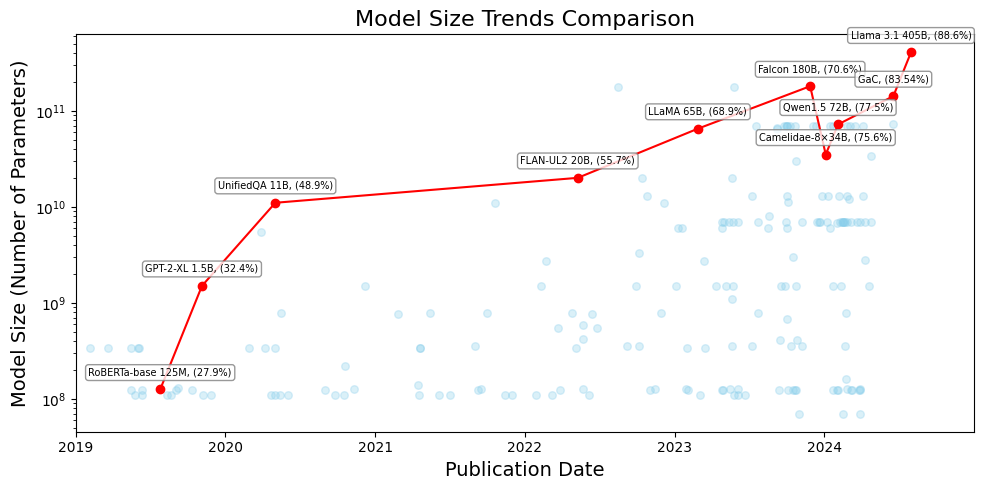

In [6]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Filter necessary columns before rolling operation
df_research_filtered = df_research[['date', 'param count']]
df_released_filtered = df_released[['date', 'param count']]


# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot
plt.scatter(df_research['date'], df_research['param count'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')

plt.plot([x.evaluation_date for x in max_score_list], open_top_params, color='red')
plt.scatter([x.evaluation_date for x in max_score_list], open_top_params, color='red')
for i, point in enumerate(max_score_list):
    plt.annotate(f"{point.method_short}, ({point.mmlu_accuracy}%)", 
                 (point.evaluation_date, open_top_params[i]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# plt.scatter(df_released['date'], df_released['param count'], 
            # color='coral', alpha=0.3, s=30)

# # Plot rolling mean lines
# plt.plot(df_research_rolling['date'], df_research_rolling['param count'], 
#          color='skyblue', linestyle='-', linewidth=2, label='Models used in research papers')
# plt.plot(df_released_rolling['date'], df_released_rolling['param count'], 
#          color='coral', linestyle='-', linewidth=2, label='Models released')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Set labels and title
ax.set_title('Model Size Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel('Model Size (Number of Parameters)', fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
# plt.legend()

# Show the plot
plt.tight_layout()
plt.show()